In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import cv2
import os
import PIL.Image
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import utils
import time
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Dropout,Dense,Flatten,BatchNormalization,Conv2D,Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import  optimizers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
%matplotlib inline 

In [3]:
infected = os.listdir('E:/ds project/mmlr_images_act/infected')
uninfected = os.listdir('E:/ds project/mmlr_images_act/uninfected')
data= []
labels= []

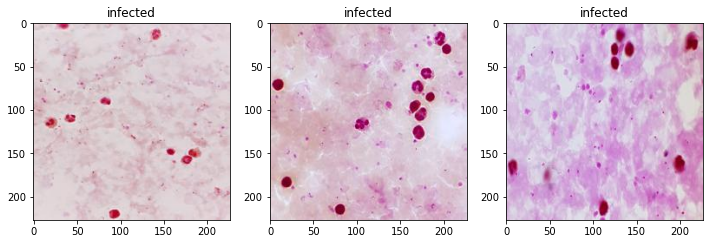

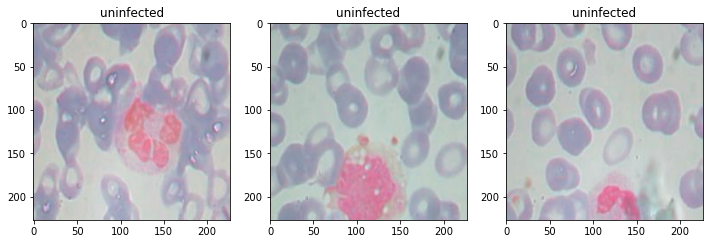

In [4]:
plt.figure(figsize=(12,12))
for i in range(3):
    plt.subplot(1,3,i+1)
    img = cv2.imread('E:/ds project/mmlr_images_act/infected/'+infected[i])
    plt.imshow(img)
    plt.title('infected')
plt.figure(figsize=(12,12))
labels.append(1)
for i in range(3):
    plt.subplot(1,3,i+1)
    img2 = cv2.imread('E:/ds project/mmlr_images_act/uninfected/'+uninfected[i])
    plt.imshow(img2)
    plt.title('uninfected')
    labels.append(0)


In [5]:
def Convert_Image_to_Array(input_path_infected, input_path_uninfected):
    data = []
    labels = []

    for i in infected:
        try:
            image = cv2.imread(input_path_infected+i)
            image_resized = cv2.resize(image,(64,64))
            image_array = img_to_array(image_resized)
            data.append(image_array)
            labels.append(1)
        except:
            print('error while reading :',i)

    for i in uninfected:
        try:
            image = cv2.imread(input_path_uninfected+i)
            image_resized = cv2.resize(image,(64,64))
            image_array = img_to_array(image_resized)
            data.append(image_array)
            labels.append(0)
        except:
            print('error while reading :',i) 
    
    data_array = np.array(data)
    labels_array = np.array(labels)
    
    idx = np.arange(data_array.shape[0]) #get all the indices of data and labels
    np.random.shuffle(idx) #randomly shuffle
    image_data = data_array[idx] #get shuffled indices data
    labels = labels_array[idx] #get shuffled labels
    image_data = image_data/255
    return image_data, labels

In [6]:
def Generate_train_val_test_Data(image_data, labels, num_of_classes):
    X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size = 0.15, random_state = 42)
    X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size = 0.17, random_state = 42)
    y_train = utils.to_categorical(y_train, num_classes = num_of_classes)
    y_val = utils.to_categorical(y_val, num_classes = num_of_classes)
    y_test = utils.to_categorical(y_test, num_classes = num_of_classes)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
def generate_data_aug(X_train, y_train):
    datagen = ImageDataGenerator(rotation_range=10, zoom_range = 0.1, width_shift_range=0.2, height_shift_range=0.2)  
    datagen.fit(X_train)
    data_from_generator = datagen.flow(X_train,y_train, batch_size = 8)
    return data_from_generator

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_learning_rate=0.0001)

In [9]:
def Create_Model_cnn(height, width, classes, channels):
    num_classes = 2
    
    model=Sequential()
    model.add(Conv2D(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    # prior layer should be flattend to be connected to dense layers
    model.add(Flatten())
    # dense layer with 50 neurons
    model.add(Dense(50, activation = 'relu'))
    # final layer with 2 neurons to classify the instances
    model.add(Dense(2, activation = 'softmax'))
    
    adam = optimizers.Adam(learning_rate = 0.0001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [10]:
def compile_build_fit_model(model, data_from_generator, X_val, y_val):
    model.compile(optimizer='adam', 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
    
    reduce = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                      factor=0.1, 
                                                      patience=5, 
                                                      mode='auto')

    early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 min_delta=1e-4, 
                                                 patience=5, 
                                                 mode='auto')
    
    model_history = model.fit(data_from_generator,epochs = 100, 
                              validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=46,
                              callbacks=[reduce, early], validation_steps=1)
    return model_history

In [11]:
image_data, labels = Convert_Image_to_Array('E:/ds project/mmlr_images_act/infected/','E:/ds project/mmlr_images_act/uninfected/')
X_train,X_val, X_test, y_train, y_val, y_test = Generate_train_val_test_Data(image_data, labels, num_of_classes = 2)
print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_val shape: ', y_val.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (437, 64, 64, 3)
X_val shape:  (90, 64, 64, 3)
X_test shape:  (93, 64, 64, 3)
y_train shape:  (437, 2)
y_val shape:  (90, 2)
y_test shape:  (93, 2)


In [12]:
data_from_generator = generate_data_aug(X_train, y_train)

In [13]:
cnn_model = Create_Model_cnn(height=64, width=64, channels=3, classes=2)
cnn_model_history = compile_build_fit_model(cnn_model,data_from_generator = data_from_generator, 
                                        X_val = X_val,
                                        y_val = y_val)

print('Fitting the model on data completed.\n training accuracy : {} \n Training loss : {}'.format(cnn_model_history.history['accuracy'][-1],cnn_model_history.history['loss'][-1]))

Epoch 1/100
46/46 [==============================] - 8s 144ms/step - loss: 0.6956 - accuracy: 0.5288 - val_loss: 0.5775 - val_accuracy: 0.9333
Epoch 2/100
46/46 [==============================] - 6s 134ms/step - loss: 0.3410 - accuracy: 0.8548 - val_loss: 0.2753 - val_accuracy: 0.8778
Epoch 3/100
46/46 [==============================] - 6s 136ms/step - loss: 0.1050 - accuracy: 0.9507 - val_loss: 0.0153 - val_accuracy: 0.9889
Epoch 4/100
46/46 [==============================] - 7s 141ms/step - loss: 0.0508 - accuracy: 0.9891 - val_loss: 0.0164 - val_accuracy: 1.0000
Epoch 5/100
46/46 [==============================] - 7s 141ms/step - loss: 0.0759 - accuracy: 0.9671 - val_loss: 0.0620 - val_accuracy: 0.9889
Epoch 6/100
46/46 [==============================] - 7s 143ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 8.5291e-04 - val_accuracy: 1.0000
Epoch 7/100
46/46 [==============================] - 8s 173ms/step - loss: 0.0353 - accuracy: 0.9891 - val_loss: 0.0011 - val_accuracy: 1.

In [14]:
cnn_testresults = cnn_model.evaluate(X_test, y_test)

print('Test results are as below \n Test accuracy : {} \n Test loss : {}'.format(cnn_testresults[1],cnn_testresults[0]))

3/3 [==============================] - 1s 125ms/step - loss: 2.3684e-04 - accuracy: 1.0000
Test results are as below 
 Test accuracy : 1.0 
 Test loss : 0.00023684276675339788


In [15]:
accuracy = cnn_model_history.history['accuracy']
loss = cnn_model_history.history['loss']
val_accuracy = cnn_model_history.history['val_accuracy']
val_loss = cnn_model_history.history['val_loss']

print(f'Training Accuracy: {np.max(accuracy)}')
print(f'Training Loss: {np.min(loss)}')
print(f'Validation Accuracy: {np.average(val_accuracy)}')
print(f'Validation Loss: {np.average(val_loss)}')

Training Accuracy: 1.0
Training Loss: 5.2541396144079044e-05
Validation Accuracy: 0.9875816948273602
Validation Loss: 0.05651564064635964


In [16]:
y_pred1 = cnn_model.predict(image_data)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
print(f'Precision Score:')

print(precision_score(labels, y_pred , average="macro"))
print(f'Recall Score:')

print(recall_score(labels, y_pred , average="macro"))
print(f'F1 Score:')
print(f1_score(labels, y_pred , average="macro"))

Precision Score:
1.0
Recall Score:
1.0
F1 Score:
1.0


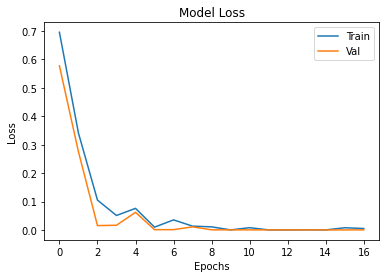

In [17]:
plt.plot(cnn_model_history.history["loss"])
plt.plot(cnn_model_history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

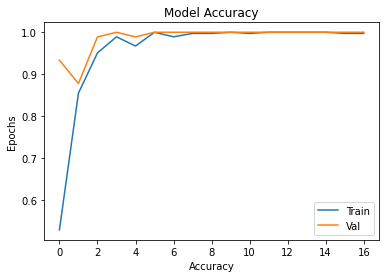

In [18]:
plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [19]:
rounded_predictions = cnn_model.predict_classes(X_test, batch_size=86, verbose=0)
rounded_predictions[1]

C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1

In [20]:
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]

1

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='weights.best.resnet.hdf5',
                               verbose=1,
                               save_best_only=True)

In [22]:
cnn_model.save_weights('weights.best.resnet.hdf5')

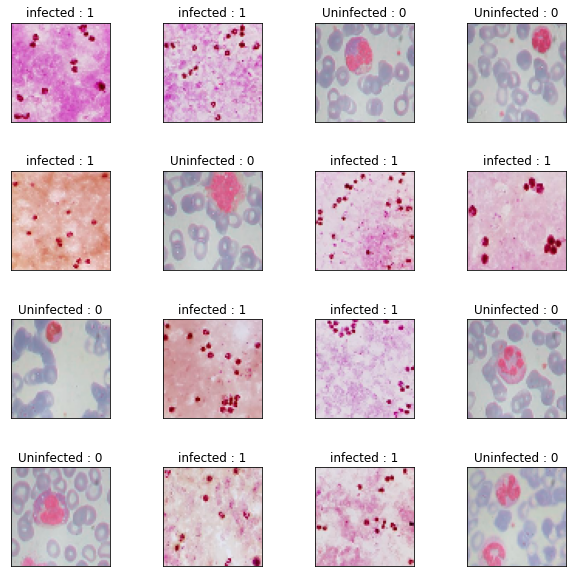

In [23]:
y_pred = cnn_model.predict_classes(X_test)
plt.figure(1, figsize=(10, 10))
n = 0
for i in range(16):
  n += 1
  r = np.random.randint(0, X_test.shape[0], 1)
  plt.subplot(4, 4, n)
  plt.subplots_adjust(hspace=0.5, wspace=0.5)
  plt.imshow(X_test[r[0]])
  plt.title('{} : {}'.format('infected' if y_pred[r[0]] == 1 else 'Uninfected',
                               y_pred[r[0]]))
  plt.xticks([]), plt.yticks([])

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, rounded_predictions)
cm

array([[52,  0],
       [ 0, 41]], dtype=int64)

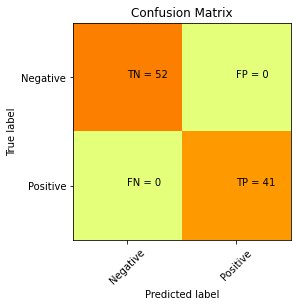

In [25]:
# PLotting confusion matrix
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [26]:
print("Accuracy:",metrics.accuracy_score(rounded_labels, rounded_predictions))
print("Precision:",metrics.precision_score(rounded_labels, rounded_predictions))
print("Recall:",metrics.recall_score(rounded_labels, rounded_predictions))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


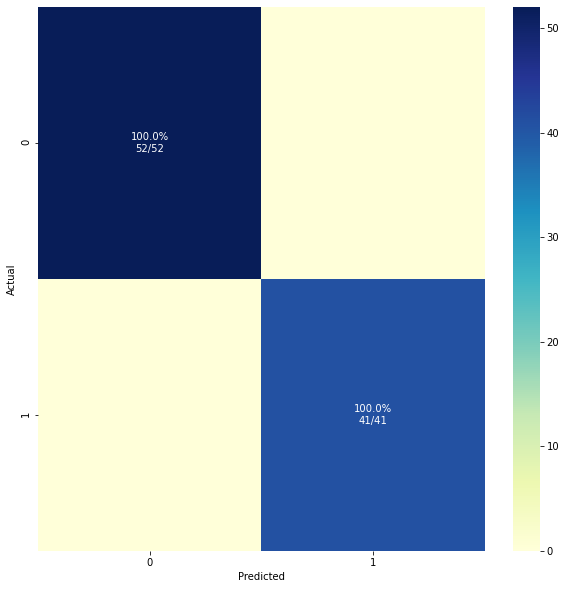

In [27]:
def plot_cm(rounded_labels, rounded_predictions, figsize=(10,10)):
    cm = confusion_matrix(rounded_labels, rounded_predictions, labels=np.unique(rounded_labels))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(rounded_labels), columns=np.unique(rounded_labels))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(rounded_labels, rounded_predictions)

In [28]:
cnf_matrix = metrics.confusion_matrix(rounded_labels, rounded_predictions)
cnf_matrix

array([[52,  0],
       [ 0, 41]], dtype=int64)

In [29]:
def calculate_sensitivity_specificity(rounded_labels, rounded_predictions):
    # Note: More parameters are defined than necessary. 
    # This would allow return of other measures other than sensitivity and specificity
    
    # Get true/false for whether a breach actually occurred
    actual_pos = rounded_labels == 1
    actual_neg = rounded_labels == 0
    
    # Get true and false test (true test match actual, false tests differ from actual)
    true_pos = (rounded_predictions == 1) & (actual_pos)
    false_pos = (rounded_predictions == 1) & (actual_neg)
    true_neg = (rounded_predictions == 0) & (actual_neg)
    false_neg = (rounded_predictions == 0) & (actual_pos)
    
    # Calculate accuracy
    accuracy = np.mean(rounded_predictions == rounded_labels)
    
    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)
    
    return sensitivity, specificity, accuracy

In [30]:

sensitivity, specificity, accuracy = calculate_sensitivity_specificity(rounded_labels, rounded_predictions)
print ('Sensitivity:', sensitivity)
print ('Specificity:', specificity)
print ('Accuracy:', accuracy)

Sensitivity: 1.0
Specificity: 1.0
Accuracy: 1.0


In [31]:
cuttoff = np.arange (0.01,1.01,0.01)
sensitivity_results = []
specificity_results = []


for threshold in cuttoff:
    # linear regression model has .predict+proba  method to return 
    # probability of outcomes. Some methods such as svc use 
    # .decision_function to return probability
        
    # Get test results 
    
    # Check probability of positive classification is >trhreshold
   #y_pred_test = (rounded_predictions[:,1] >= threshold)
    
    # Convert boolean to 0/1 (could also simply multiple by 1)
    #y_pred_test = y_pred_test.astype(int)
    
    # Get sensitivity and specificity
    sensitivity, specificity, accuracy = \
        calculate_sensitivity_specificity(rounded_labels, rounded_predictions)
    
    # Add results to list of results
    sensitivity_results.append(sensitivity)
    specificity_results.append(specificity)

In [32]:

y_true = rounded_labels
y_prediction = rounded_predictions
cnf_matrix = confusion_matrix(y_true, y_prediction)
print(cnf_matrix)
#[[1 1 3]
# [3 2 2]
# [1 3 1]]

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
print('False Positive rate:')
print(FP)
print('False Negative rate:')
print(FN)
print('True Positive rate:')
print(TP)
print('True Negative rate:')
print(TN)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('Sensitivity:')
print(TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('Specificity:')
print(TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('precision:')
print(PPV)
# Negative predictive value
NPV = TN/(TN+FN)
print('Negative Predictive:')
print(NPV)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('False positive:')
print(FPR)
# False negative rate
FNR = FN/(TP+FN)
print('False Negative:')
print(FNR)
# False discovery rate
FDR = FP/(TP+FP)
('False dicovery:')
print(FDR)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy:')
print(ACC)

[[52  0]
 [ 0 41]]
False Positive rate:
[0. 0.]
False Negative rate:
[0. 0.]
True Positive rate:
[52. 41.]
True Negative rate:
[41. 52.]
Sensitivity:
[1. 1.]
Specificity:
[1. 1.]
precision:
[1. 1.]
Negative Predictive:
[1. 1.]
False positive:
[0. 0.]
False Negative:
[0. 0.]
[0. 0.]
Accuracy:
[1. 1.]


In [33]:
from sklearn.metrics import matthews_corrcoef
y_true = rounded_labels
y_pred = rounded_predictions
print('Matthews Correlation Coefficient Score is:')
matthews_corrcoef(y_true, y_pred)

Matthews Correlation Coefficient Score is:


1.0

In [34]:
y_true = np.array(rounded_labels)
y_scores = np.array(rounded_predictions)
print('Area Under The Curve')
roc_auc_score(y_true, y_scores)

Area Under The Curve


1.0

In [35]:
auc = roc_auc_score(rounded_labels, rounded_predictions)

In [36]:
fpr, tpr, thresholds = roc_curve(rounded_labels, rounded_predictions)

In [37]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

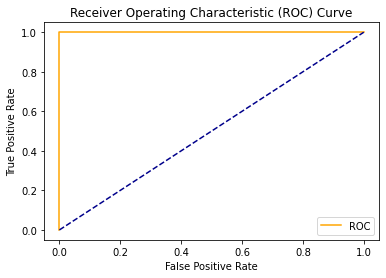

In [38]:
plot_roc_curve(fpr, tpr)